# Morphology

In [1]:
from utils import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def apply_morphological_operation(img, s_e, operator = 'EROSION'):
    result_image = np.zeros(img.shape)
    x_window_size = s_e.shape[0] // 2
    y_window_size = s_e.shape[1] // 2
    
    for j in range(x_window_size, img.shape[0] - x_window_size):
        for i in range(y_window_size, img.shape[1] - y_window_size):
            pos_x = i + x_window_size
            neg_x = i - x_window_size
            pos_y = j + y_window_size
            neg_y = j - y_window_size
            
            if operator == 'EROSION':
                result_image[j+y_window_size, i+x_window_size] = np.min(np.min(
                        np.logical_and(img[neg_y : pos_y+1, neg_x: pos_x+1], s_e)
                    ))
                
            elif operator == 'DILATION':
                result_image[j+y_window_size, i+x_window_size] = np.max(np.max(
                        np.logical_and(img[neg_y : pos_y+1, neg_x: pos_x+1], s_e)
                    )) 
                
            else:
                raise Exception('Invalid operator')   

    return result_image 


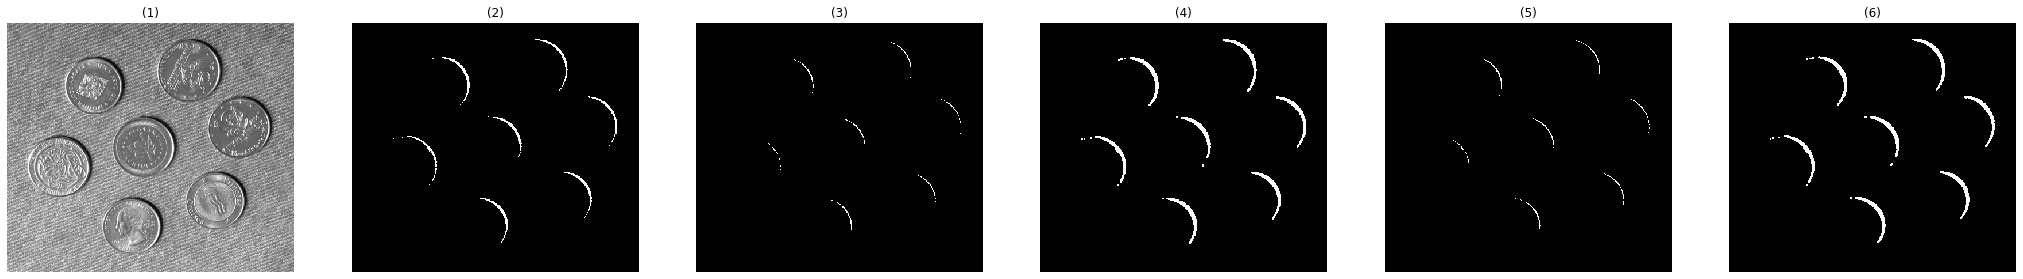

In [5]:

img = rgb2gray(io.imread('./images/coins.jpg'))

threshhold = 60/255
mask = img < threshhold
binary_img = np.zeros(img.shape)
binary_img[mask] = 1

s_e = np.array([[1,1,1], [1,1,1], [1,1,1]])

img_w_erosion = apply_morphological_operation(binary_img, s_e)
img_w_dilation = apply_morphological_operation(binary_img, s_e, 'DILATION')

img_w_skimage_erosion = binary_erosion(binary_img, s_e)
img_w_skimage_dilation = binary_dilation(binary_img, s_e)

show_images([img, binary_img, img_w_erosion, img_w_dilation, 
             img_w_skimage_erosion, img_w_skimage_dilation
             ])

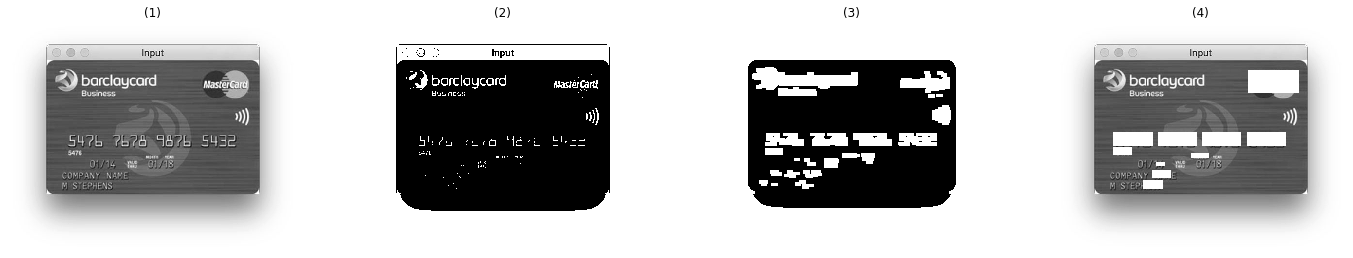

In [25]:
'''
Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''
# Load the image
card_img = rgb2gray(io.imread('./images/card.jpg'))

# Apply binary thresholding
threshhold = 0.74
binary_card_img = np.zeros(card_img.shape)
mask = card_img > threshhold
binary_card_img[mask] = 1

# Apply dilation
s_e = np.array([[1,1,1], [1,1,1]])
dilated_img = np.copy(binary_card_img)

for i in range(6):
    dilated_img = binary_dilation(dilated_img, s_e)

# Get the contours
countours = find_contours(dilated_img, 0.8)

# Convert contours to bounding boxes
bounding_boxes = []
for i in countours[1:]:
    min_x = int(min(i[:,1]))
    min_y = int(min(i[:,0]))
    max_x = int(max(i[:,1]))
    max_y = int(max(i[:,0]))
    
    # Filter contours on aspect ratio
    aspect_ratio = (max_y - min_y)/(max_x - min_x)
    if aspect_ratio > 0.3 and aspect_ratio < 0.5:
        bounding_boxes.append((min_x, max_x, min_y, max_y))

# Draw boxes on the original image
img_with_boxes = np.copy(card_img)
for box in bounding_boxes:
    [min_x, max_x, min_y, max_y] = box
    rr, cc = rectangle(start = (min_y,min_x), end = (max_y,max_x), shape=card_img.shape)
    img_with_boxes[rr, cc] = 1 # set color white

show_images([card_img, binary_card_img, dilated_img, img_with_boxes])

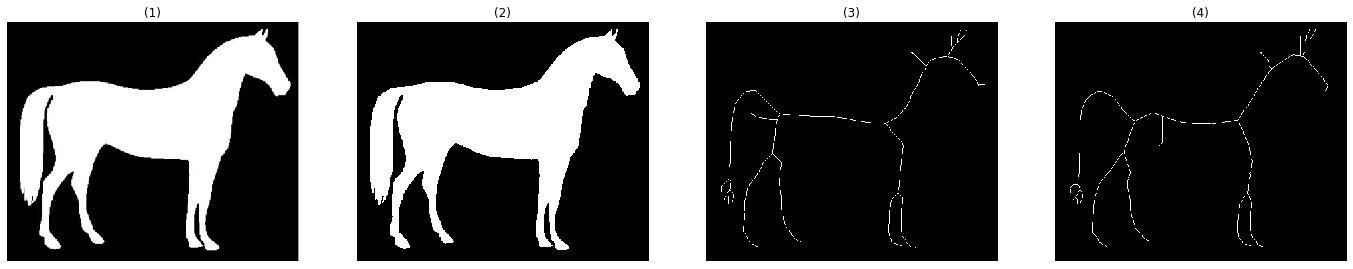

In [8]:
'''
Skeletonization:
'''

horse_img = rgb2gray(io.imread('./images/horse.jpg'))

# Use a binary threshold of 0.9 to remove invisible noise in the background
mask = horse_img > 0.9
new_horse = np.zeros(horse_img.shape)
new_horse[mask] = 1

# Apply skeletonization, thinning and show the results
skeleton_img = skeletonize(new_horse)
thinned_img = thin(new_horse, 100)

show_images([horse_img, new_horse, skeleton_img, thinned_img])